# Rusty level pymc3 model with GP variations

In [13]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
import random
import sys
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from zero_point import zpt
from tqdm import tqdm
import warnings
import astropy.table as astab
from astropy.io import fits
from optparse import OptionParser
import helper_functions as hf
warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
import os
import shutil
import pickle as pk
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name


import sys
what_machine_am_i_on = sys.platform


import theano
theano.config.reoptimize_unpickled_function = False 

if what_machine_am_i_on=='linux' or what_machine_am_i_on=='linux2':
    theano.config.optimizer = 'None'
    theano.config.mode = 'FAST_COMPILE'
    theano.config.cxx = ""

import exoplanet as xo

import arviz as az
from corner import corner




def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

tic_systems_of_interest = [
    28159019,
    272074664,
    20215452,
    99254945,
    165453878,
    164458426,
    164527723,

    144441148,
    169820068,
    126232983,
    258108067,
    271548206,
    365204192
    ]

from isochrones import get_ichrone
zpt.load_tables()
from zero_point import zpt

In [14]:
hf.get_nearest_eep_and_evol_state(TIC_ID='TIC 144441148',ndraws=50)

0.2021699994802475 0.004157739225775003
Report on TIC 144441148.
M1 has a mass: 0.374 Msol, radius: 0.858 Rsol, logG: 3.760312 and stellar type None
M2 has a mass: 0.084 Msol, radius: 0.758 Rsol, logG: 2.508566 and stellar type None
The binary system has inclination: 1.417, semi-major axis: 10.490 AU, and ecc: 0.016766.
This binary system has a period of 5.819 days.
{'m1': array(0.37379073), 'm1e': 0.17516592915471682, 'r1': array(0.85754171), 'r1e': 0.21589703572742933, 'logg1': 3.7603117427091655, 'logg1e': 0.47538282804394993, 'stype1': 'None', 'm2': array(0.08356134), 'm2e': 0.024772627970118758, 'r2': array(0.75815298), 'r2e': 0.2656533507028073, 'logg2': 2.5085659184968385, 'logg2e': 0.6220092039600263, 'stype2': 'None', 'a': array(10.48979807), 'incl': array(1.41747), 'ecc': array(0.0167657), 'period': array(5.81856142), 'omega': array(0.43807107)}


100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.61it/s]


N successful draws: 11 out of 50
202 119.53187942504883 1 56.83347702026367
The system appears to be 6.602909387179093 logt 
M1 appears to be in the ZAMS state, and is approaching the IAMS state
M2 appears to be in the PMS state, having left the PMS state


In [15]:
trks = get_ichrone('mist', bands=['G','BP','RP','eG3','eBP3','eRP3','J','H','K'])
df = trks.isochrone(9, feh=0.4)
from isochrones.mist import MIST_EvolutionTrack
mtrack = MIST_EvolutionTrack()
mtrack.interp_value([1.0,600, 0.0], ['logg','radius','mass'])

DR2_rev
DR2_rev
DR2_rev
using eDR3 bands.
using eDR3 bands.
using eDR3 bands.


array([1.06264766e-01, 1.43921042e+02, 9.64644158e-01])

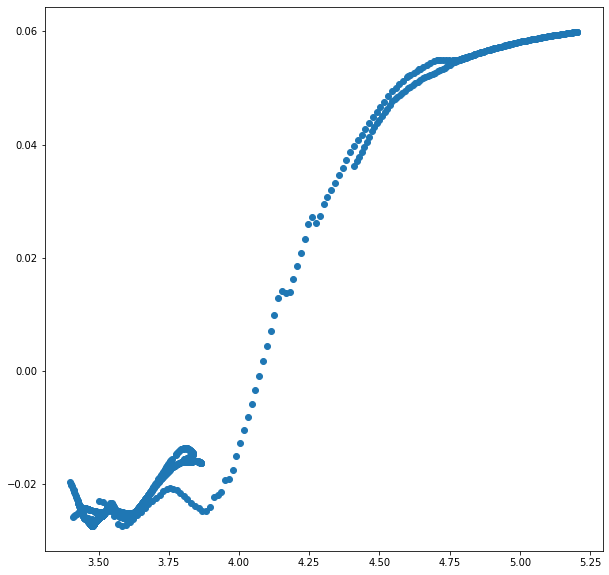

In [16]:
fig,ax = plt.subplots(figsize=(10,10))
cbax = ax.scatter(np.log10(df['Teff']), (df['eBP3_mag'] - df['H_mag']) - (df['BP_mag'] - df['H_mag']))
x1,x2 = ax.set_xlim()
y1,y2 = ax.set_ylim()
# ax.set_xlim(min(x1,y1), max(x2,y2))
# ax.set_ylim(min(x1,y1), max(x2,y2))


#### housekeeping to load dicts and construct relevant arrays

running on macOS
theano_root_dir = /Users/karljaehnig/CCA_work/GAT/mcmc_chains/
running with multiplicative factor of 32x
starting model setup and run for TIC-169820068
There is already a directory for TIC 169820068.
25.097999999999956
lightcurve N datapoints:  47901 47901 47901 transit_epoch:  25.097999999999956
14.770308
17.0
running inter-transit phase curve sparsification
sparsifying inter-transit phase curve
There is already a directory for TIC 169820068.
0.001388888888888889
ecosw_tv:  0.780809512442886
calculated ecosw_tv too high. Resetting to 0.01
########## Ready to build model. ##########
12.43414161024814
8.504802083703575


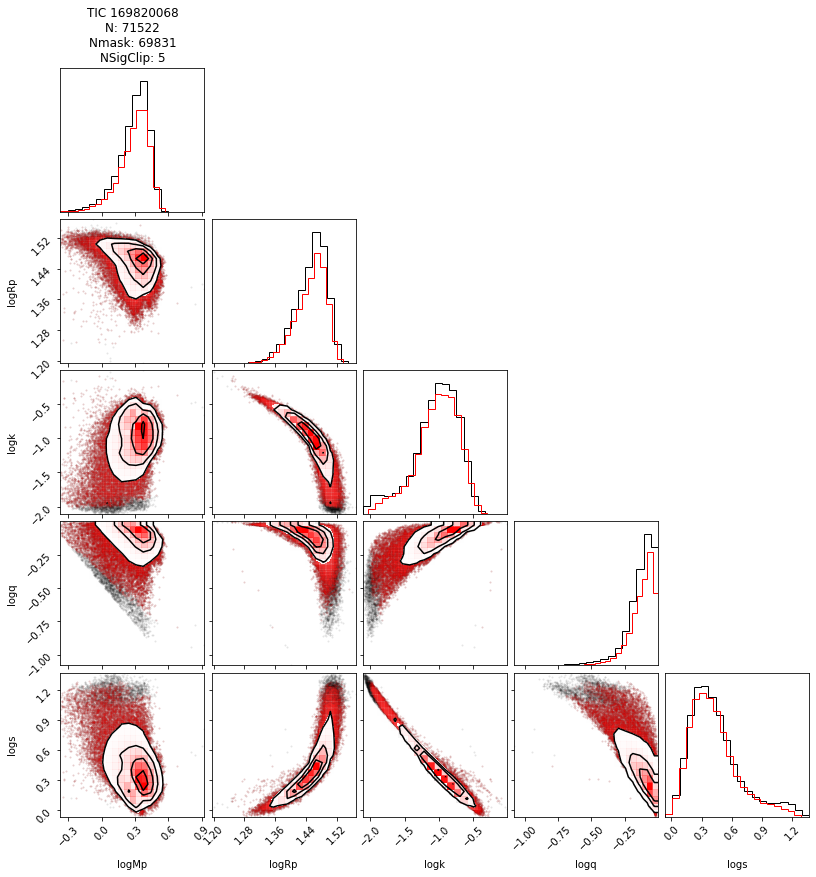

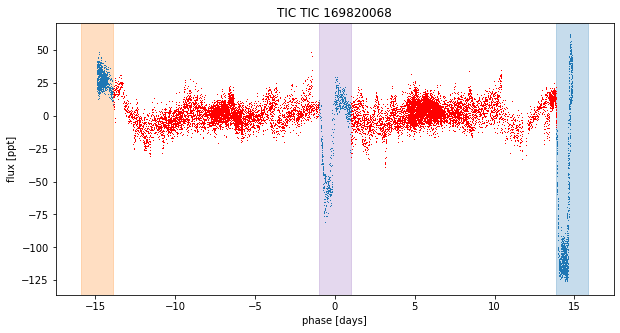

In [17]:
DD = hf.load_system_specific_directory()
TIC_TARGET = '169820068'
chains = 4
mult_factor = 32
mu_factor = 1.0
Ndraw = 100
Ntune = 500
sparse_factor = 5
durf = 10
sparsify_phase_curve = True

theano_root = DD + f"mcmc_chains/"

print(f'theano_root_dir = {theano_root}')

if not os.path.exists(theano_root):
    os.mkdir(theano_root)


theano_path = theano_root + f"mcmc_{TIC_TARGET}_c{chains}_nt{Ntune}_nd{Ndraw}/"
if os.path.exists(theano_path):
    shutil.rmtree(theano_path)
os.mkdir(theano_path)
os.environ["THEANO_FLAGS"] = f"base_compiledir={theano_path}"

mf = mult_factor
print(f"running with multiplicative factor of {int(mult_factor)}x")


##sys.stdout = open('file', 'w')
print(f'starting model setup and run for TIC-{TIC_TARGET}')
##sys.stdout.close()
TIC_TARGET = f'TIC {TIC_TARGET}'


# pymc3_model_dict = hf.load_precompiled_pymc3_model_data(DD, TIC_TARGET,
                                                    # sparse_factor=sparse_factor)
    
res, blsres, sysapodat = hf.get_system_data_for_pymc3_model(TIC_TARGET)

pymc3_model_dict = hf.load_all_data_for_pymc3_model(
    TIC_TARGET, 
    sparse_factor=5,
    dur=10,
    save_data_to_dict=False, 
    nsig=5, 
    sparsify_phase_curve=True)


tic_dest, fig_dest = hf.check_for_system_directory_rusty_side(DD,TIC_TARGET, return_directories=True)

texp = pymc3_model_dict['texp']
print(texp)
x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']


# f = open("/Users/karljaehnig/CCA_work/GAT/ceph/highres_bls/TIC_169820068_highres_bls_params.pickle",'rb')
# blsres = pk.load(f)
# f.close()
# lit_period = blsres['period_at_max_power'].value
# lit_t0 = blsres['t0_at_max_power'].btjd - pymc3_model_dict['x_lk_ref']
# Ntrans = np.floor((x.max() - lit_t0) / lit_period)
# print(Ntrans)
# lit_tn = lit_t0  + Ntrans * lit_period


lk_sigma = pymc3_model_dict['lk_sigma']

#lit_period = pymc3_model_dict['lit_period'],
# lit_t0 = pymc3_model_dict['lit_t0'] 
# lit_tn = pymc3_model_dict['lit_tn']



Ntrans = pymc3_model_dict['Ntrans']
ecosw_tv = pymc3_model_dict['ecosw_tv']
print('ecosw_tv: ', ecosw_tv)
if abs(ecosw_tv) > 0.01:
    print(f"calculated ecosw_tv too high. Resetting to {np.sign(ecosw_tv) * 0.01}")
    ecosw_tv = np.sign(ecosw_tv) * 0.01

lit_period = res['joker_param']['MAP_P']
lit_t0 = astropy.time.Time(res['joker_param']['MAP_t0_bmjd'], format='mjd', scale='tcb').btjd
lit_tn = lit_t0 + Ntrans * lit_period


SUFFIX = f'individual_priors_{int(mf)}x_isochrones'

LOGiso_M1 = pymc3_model_dict['isores']['logm1']
LOGiso_R1 = pymc3_model_dict['isores']['logr1']
LOGiso_q = pymc3_model_dict['isores']['logq']
LOGiso_k = pymc3_model_dict['isores']['logk']
LOGiso_s = pymc3_model_dict['isores']['logs']


trv = np.linspace(x_rv.min(), x_rv.max(), 5000)
tlc = np.arange(x.min(), x.max(), np.median(np.diff(x)))



print("#"*10,'Ready to build model.','#'*10)


lk = pymc3_model_dict['model_lk_data']
# blsres = pymc3_model_dict['blsres']
transit_mask = lk.create_transit_mask(
    period=blsres['period_at_max_power'].value,
    duration=5*blsres['duration_at_max_power'].value,
    transit_time=blsres['t0_at_max_power']
)

dur1 = blsres['duration_at_max_power'].value
# x=lk[~transit_mask].time.value
# y=lk[~transit_mask].flux.value
fig,ax = plt.subplots(figsize=(10,5))
foldedx = hf.fold(x, lit_period, lit_t0)
inds = np.argsort(foldedx)
ax.plot(foldedx[inds], y[inds], ls='',marker=',')
print(lk_sigma)



ax.axvspan(0.5*lit_period - durf*dur1,0.5*lit_period + durf*dur1, color='C0',alpha=0.25)
ax.axvspan(-0.5*lit_period - durf*dur1, -0.5*lit_period + durf*dur1, color='C1',alpha=0.25)

ax.axvspan(0 - durf*dur1, 0 + durf*dur1, color='C4',alpha=0.25)

mask1 = (foldedx[inds] > 0.5*lit_period - durf*dur1) & (foldedx[inds] < 0.5*lit_period + durf*dur1)
mask2 = (foldedx[inds] > -0.5*lit_period - durf*dur1) & (foldedx[inds] < -0.5*lit_period + durf*dur1)
mask3 = (foldedx[inds] > -durf*dur1) & (foldedx[inds] < durf*dur1)

cmplt_mask = ~mask1&~mask2&~mask3
print(np.std(y[inds][cmplt_mask]))
ax.plot(foldedx[inds][cmplt_mask], y[inds][cmplt_mask],c='red',ls='None',marker=',')
lk_sigma = np.std(y[inds][cmplt_mask])
ax.set_xlabel("phase [days]")
ax.set_ylabel("flux [ppt]")
ax.set_title(f"TIC {TIC_TARGET}")
plt.savefig(DD+f"TIC_{TIC_TARGET}_example_eclipse_phase_curve.png",dpi=150,bbox_inches='tight')

In [18]:
# blsres2 = hf.highres_secondary_transit_bls(pymc3_model_dict['model_lk_data'],blsres)

# hf.estimate_ecosw(blsres,blsres2)
# lk = pymc3_model_dict['model_lk_data']
# blsres = pymc3_model_dict['blsres']
# transit_mask = lk.create_transit_mask(
#     period=blsres['period_at_max_power'].value,
#     duration=5*blsres['duration_at_max_power'].value,
#     transit_time=blsres['t0_at_max_power']
# )

# dur1 = blsres['duration_at_max_power'].value
# # x=lk[~transit_mask].time.value
# # y=lk[~transit_mask].flux.value
# fig,(ax,ax1,ax2) = plt.subplots(ncols=3,figsize=(15,5))
# foldedx = hf.fold(x, lit_period, lit_t0)
# inds = np.argsort(foldedx)
# ax.plot(foldedx[inds], y[inds], ls='',marker=',')
# print(lk_sigma)


# durF = 3.5
# ax.axvspan(0.5*lit_period - durF*dur1,0.5*lit_period + durF*dur1, color='C0',alpha=0.25)
# ax.axvspan(-0.5*lit_period - durF*dur1, -0.5*lit_period + durF*dur1, color='C1',alpha=0.25)

# ax.axvspan(0 - durF*dur1, 0 + durF*dur1, color='C4',alpha=0.25)

# mask1 = (foldedx[inds] > 0.5*lit_period - durF*dur1) & (foldedx[inds] < 0.5*lit_period + durF*dur1)
# mask2 = (foldedx[inds] > -0.5*lit_period - durF*dur1) & (foldedx[inds] < -0.5*lit_period + durF*dur1)
# mask3 = (foldedx[inds] > -durF*dur1) & (foldedx[inds] < durF*dur1)

# cmplt_mask = ~mask1&~mask2&~mask3
# print(np.std(y[inds][cmplt_mask]))
# ax.plot(foldedx[inds][cmplt_mask], y[inds][cmplt_mask],c='red',ls='None',marker=',')
# lk_sigma = np.std(y[inds][cmplt_mask])

# ax.plot(foldedx[inds][~cmplt_mask], y[inds][~cmplt_mask],c='blue',ls='None',marker=',')

# x1,y2,yerr2,m = hf.run_with_sparse_data(foldedx[inds][cmplt_mask],
#                                         y[inds][cmplt_mask],
#                                         yerr[inds][cmplt_mask],
#                                         sparse_factor=5,return_mask=True)

# ax1.plot(x[inds][~cmplt_mask], y[inds][~cmplt_mask],c='blue',ls='None',marker=',')
# ax1.plot(x[inds][cmplt_mask][m], y[inds][cmplt_mask][m],c='red',ls='None',marker=',')
# ax1.set_xlim(0,3*lit_period)

# x_ = np.append(x[inds][~cmplt_mask], x[inds][cmplt_mask][m])
# y_ = np.append(y[inds][~cmplt_mask], y[inds][cmplt_mask][m])
# yerr_ = np.append(yerr[inds][~cmplt_mask], yerr[inds][cmplt_mask][m])

# x_ = np.ascontiguousarray(x_, dtype=np.float64)
# y_ = np.ascontiguousarray(y_, dtype=np.float64)
# yerr_ = np.ascontiguousarray(yerr_, dtype=np.float64)

# x_inds = np.argsort(x_)
# y_ = y_[x_inds]
# yerr_ = yerr_[x_inds]
# x_ = x_[x_inds]

# foldedx_ = hf.fold(x_, lit_period, lit_t0)
# inds_ = np.argsort(foldedx_)
# ax2.plot(foldedx_[inds_], y_[inds_], ls='None',marker=',')

# if len(x) > 1.5e3:
#     print("Cutting out phase curve between eclipses.")
#     x,y,yerr = x_, y_, yerr_
#     pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr'] = x,y,yerr
#     print(len(x))

In [19]:
# mask = x < 400
# 0.297943678843811
def build_model(mask=None, start=None, suffix=None, pymc3_model_dict=None):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", mu=mu_factor*LOGiso_M1[0], sigma=mf*LOGiso_M1[1], testval=mu_factor*LOGiso_M1[0])
        log_R1 = pm.Normal("log_R1", mu=mu_factor*LOGiso_R1[0], sigma=mf*LOGiso_R1[1], testval=mu_factor*LOGiso_R1[0])

        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))


        # Secondary ratios
        log_k = pm.Normal("log_k", mu=mu_factor*LOGiso_k[0], sigma=mf*LOGiso_k[1], testval = mu_factor*LOGiso_k[0])  # radius ratio        
        log_q = pm.Normal("log_q", mu=mu_factor*LOGiso_q[0], sigma=mf*LOGiso_q[1], testval = mu_factor*LOGiso_q[0])  # mass ratio
        log_s = pm.Normal("log_s", mu=mu_factor*LOGiso_s[0], sigma=mf*LOGiso_s[1], testval = mu_factor*LOGiso_s[0])  # surface brightness ratio


        k = pm.Deterministic("k", tt.exp(log_k))
        q = pm.Deterministic("q", tt.exp(log_q))
        s = pm.Deterministic("s", tt.exp(log_s))


        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=0.5)

#         log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
#         period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=3.0, testval=lit_t0)
        tn = pm.Normal("tn", mu=lit_tn, sigma=3.0, testval=lit_tn)
        period = pm.Deterministic("period", (tn - t0) / Ntrans)
        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
#         ecosw_tv=0.01
        sqrt_ecosw = np.sign(ecosw_tv) * np.sqrt(abs(ecosw_tv))
        # ecs is now sqrt(ecs) even if variable name is still ecs
        ecs = pmx.UnitDisk("ecs", testval=np.array([sqrt_ecosw, 0.0]))
        # remove sqrt from ecc, rewrite as ecosW and esinW



        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        print(f"ecs: {ecs[0]},{ecs[1]}, ecc: {ecc}")
        # if ecc not in range(0,1): sdsd =sdsd
        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)




        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval= np.mean(yerr),
            **pmx.estimate_inverse_gamma_parameters(0.1,5.0)
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval= lk_sigma,
            **pmx.estimate_inverse_gamma_parameters(0.1, 15.0),
        )
        
        #### 
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval= 2.*lit_period,
            **pmx.estimate_inverse_gamma_parameters(0.1,15.0),
        )
        
        # q_gp = pm.Uniform(
        #     "q_gp",
        #     lower=1./10.,
        #     upper=1./1.01,
        #     testval=1./4
        # )
#         sigma_lc = np.mean(yerr) 
#         sigma_gp = lk_sigma
#         rho_gp = 0.25*lit_period
        print(sigma_lc, sigma_gp, rho_gp)
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1./4.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

#         pm.Deterministic(
#             "lc_pred",
#             model_lc(x)
#         )

        # Condition the light curve model on the data
        # gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc = GaussianProcess(
                    kernel_lc, 
                    t = x[mask], 
                    yerr = sigma_lc + yerr[mask]**2.,
                    mean = mean_lc)
        
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))


#         # Set up the radial velocity model

        log_sigma_rv =  pm.Bound(pm.Normal, upper=np.log(10))(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=10.0, testval=np.log(np.median(yerr_rv))
        )

        def model_rv(t):
            return orbit.get_radial_velocity(t, output_units=u.km/u.s) + mean_rv

        rv_model = model_rv(x_rv)

#         def model_K(t, period, t0):
#             rvs = model_rv(t)
#             modK = xo.estimate_semi_amplitude(period, t, rvs, yerr_rv, t0).to(u.km/u.s)
#             return modK

        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))

        pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        ## compute phased RV signal
#         n = 2.*np.pi * (1./period)
#         phi = (t0 * n) - omega
#         phase = np.linspace(0, 1, 500)
#         M_pred = 2 * np.pi * phase - (phi + omega)
#         f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))

# #         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
#         K = (tt.max(rv_model) - tt.min(rv_model)) / 2.

#         rvphase = pm.Deterministic(
#             "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
#         )
#         n = 2.*np.pi * (1./period)
#         phi = (t0 * n) - omega
#         phase = np.linspace(0, 1, 500)
#         M_pred = 2 * np.pi * phase - (phi + omega)
#         f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))

# #         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
#         K = (tt.max(rv_model) - tt.min(rv_model)) / 2.

#         rvphase = pm.Deterministic(
#             "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
#         )

        # Optimize the logp
        if start is None:
            start = model.test_point


        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            yerr_rv = yerr_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )


        # First the RV parameters
        print(model.check_test_point())
        opti_logp = []
        filename_list = []
        map_vars_dict = {
            't0_tn' : [tn,t0],
            'u1_u2' : [u1, u2],
            'log_q' : log_q,
            'log_s' : log_s,
            'log_M1': log_M1,
            'log_R1': log_R1,
            'mean_lc': mean_lc,
            'mean_rv': mean_rv,
        }
        list_of_map_vars = list(map_vars_dict.keys())


        filename_base = f"{fig_dest}{TIC_TARGET.replace(' ','_')}_{suffix}"

        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, start, extras, mask, 
                                                 title=' after start point opt step',
                                                 filename=filename_base + ' after start point opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)

        # start, info_ = pmx.optimize(start, [log_M1,log_k,log_s], return_info=True)        

        map_soln, info_ = pmx.optimize(start, log_k, return_info=True)
        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='after log_k opt step',
                                                 filename=filename_base + ' after log_k opt step.png'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        log_k_logp = -info_['fun']
        filename_list.append(plot)
        if ~np.isfinite(-info_['fun']):
            list_of_map_vars.append('log_k')
            map_vars_dict['log_k'] = log_k

        map_soln, info_ = pmx.optimize(map_soln, b, return_info=True)
        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after b opt step',
                                                 filename = filename_base + ' after b opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        b_logp = -info_['fun']
        filename_list.append(plot)
        if ~np.isfinite(-info_['fun']):
            list_of_map_vars.append('b')
            map_vars_dict['b'] = b

        map_soln, info_ = pmx.optimize(map_soln, ecs, return_info=True)
        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='model after [ecs] opt step',
                                                 filename=filename_base + ' model after [ecs] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        ecs_logp = -info_['fun']
        filename_list.append(plot)
        if ~np.isfinite(-info_['fun']):
            list_of_map_vars.append('ecs')
            map_vars_dict['ecs'] = ecs


        print("looping over",list(map_vars_dict.keys()))
        best_map_list = []
        whileloop_failsafe = 0
        while len(list_of_map_vars) > 0:
            highest_logp = -np.inf
            random.shuffle(list_of_map_vars)
            try:
                next_map_var = []
                next_map_soln = []
                next_opti_logp = np.nan
                for ii in list_of_map_vars:
#                     print(f"optimizing {ii}") 
                    map_soln_ii, info_ = pmx.optimize(map_soln, map_vars_dict[ii], return_info=True, verbose=False)

                    if np.isfinite(-info_['fun']):
                        if -info_['fun'] > highest_logp:
                            next_map_var = ii
                            next_map_soln = map_soln_ii
                            next_opti_logp = -info_['fun']
                            highest_logp = -info_['fun']

                opti_logp.append(next_opti_logp)
                map_soln = next_map_soln
                list_of_map_vars.remove(next_map_var)
                best_map_list.append(next_map_var)

                print("-"*50)
                logp0,logp1 = opti_logp[-2],opti_logp[-1]
                print(f"N_best: {len(best_map_list)}, N_left: {len(list_of_map_vars)}, {next_map_var}, logp: {logp0} -> {logp1}")
                plotn = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f' after {next_map_var} opt step', 
                                                          filename=filename_base + f' after {next_map_var} opt step'.replace(' ','_'),
                                                          RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
                filename_list.append(plotn)

            except:
                print("loop failed")
                whileloop_failsafe += 1
                print(whileloop_failsafe)
            if whileloop_failsafe > 20:
                break


        # map_soln, info_ = pmx.optimize(map_soln, [sigma_lc, sigma_gp, rho_gp, q_gp], return_info=True)
        map_soln, info_ = pmx.optimize(map_soln, [sigma_lc, sigma_gp, rho_gp], return_info=True)
        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after GP params opt step',
                                                 filename=filename_base + ' after GP params opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)

        map_soln, info_ = pmx.optimize(map_soln, [log_sigma_rv], return_info=True)
        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after lsig_rv params opt step',
                                                 filename=filename_base + ' after lsig_rv params opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)

        map_soln, info_ = pmx.optimize(map_soln, 
                                       return_info=True)
        plot = hf.plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after final opt step',
                                                 filename=filename_base+' after final opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot) 





    plt.close()
    return model, map_soln, extras, start, opti_logp, filename_list



model, map_soln, extras, start, opti_logp, filename_list = \
    build_model(suffix=SUFFIX, pymc3_model_dict=pymc3_model_dict)


with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )

resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
plt.savefig(fig_dest + f"{TIC_TARGET}_{SUFFIX}_sigma_cliped_lightcurve_plot.png", dpi=150, bbox_inches='tight')
plt.close()

print("#" * 50)
print("Starting 2nd round of MAP optimizations.")
print("#" * 50)
SUFFIX2 = SUFFIX + "_2nd_rnd"
model, map_soln, extras, start, opti_logp,_ = build_model(
        mask, map_soln, suffix=SUFFIX2, pymc3_model_dict=None)

ecs: Subtensor{int64}.0,Subtensor{int64}.0, ecc: ecc ~ Deterministic
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                          -3.22
mean_rv                          -4.83
u1_quadlimbdark__                -2.77
u2_quadlimbdark__                -2.77
log_M1                           -2.39
log_R1                           -1.15
log_k                            -3.22
log_q                            -2.02
log_s                            -2.93
b_impact__                       -1.46
t0                               -2.02
tn                               -2.02
ecs_unitdisk+interval__          -1.40
sigma_lc_log__                   -3.98
sigma_gp_log__                   -3.62
rho_gp_log__                     -6.14
log_sigma_rv_upperbound__        -1.70
obs_lc                      -103458.18
obs                           -9538.37
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -113044.19700034717 -> -85240.02429339243
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -85240.02429339243 -> -83391.05598337518
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -83391.05598337518 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model



looping over ['t0_tn', 'u1_u2', 'log_q', 'log_s', 'log_M1', 'log_R1', 'mean_lc', 'mean_rv', 'ecs']
--------------------------------------------------
loop failed
1
--------------------------------------------------
N_best: 2, N_left: 7, ecs, logp: -76024.15432799664 -> -75216.80994095175
--------------------------------------------------
N_best: 3, N_left: 6, u1_u2, logp: -75216.80994095175 -> -74718.22992708467
--------------------------------------------------
N_best: 4, N_left: 5, log_q, logp: -74718.22992708467 -> -74622.78452023714
--------------------------------------------------
N_best: 5, N_left: 4, log_s, logp: -74622.78452023714 -> -74544.82013232574
--------------------------------------------------
N_best: 6, N_left: 3, mean_rv, logp: -74544.82013232574 -> -74517.08177265283
--------------------------------------------------
N_best: 7, N_left: 2, log_R1, logp: -74517.08177265283 -> -74514.56446674994
--------------------------------------------------
N_best: 8, N_left: 1,

optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -74507.50677113072 -> -61507.11083785447
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -61507.11083785447 -> -61114.84962938255
optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -61114.84962938255 -> -60681.639981352324


##################################################
Starting 2nd round of MAP optimizations.
##################################################
ecs: Subtensor{int64}.0,Subtensor{int64}.0, ecc: ecc ~ Deterministic
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                          -3.22
mean_rv                          -4.83
u1_quadlimbdark__                -2.77
u2_quadlimbdark__                -2.77
log_M1                           -2.39
log_R1                           -1.15
log_k                            -3.22
log_q                            -2.02
log_s                            -2.93
b_impact__                       -1.46
t0                               -2.02
tn                               -2.02
ecs_unitdisk+interval__          -1.40
sigma_lc_log__                   -3.98
sigma_gp_log__                   -3.62
rho_gp_log__                     -6.14
log_sigma_rv_upperbound__        -1.70
obs_lc                      -102707.81
obs             

optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -59995.79538912179 -> -59995.78672657758


optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -59995.78672657758 -> -59995.78671544219
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -59995.78671544219 -> -59995.78585903583


looping over ['t0_tn', 'u1_u2', 'log_q', 'log_s', 'log_M1', 'log_R1', 'mean_lc', 'mean_rv']
--------------------------------------------------
loop failed
1
--------------------------------------------------
N_best: 2, N_left: 6, t0_tn, logp: -59995.7487576991 -> -59995.74677140357
--------------------------------------------------
N_best: 3, N_left: 5, mean_lc, logp: -59995.74677140357 -> -59995.745842890865
--------------------------------------------------
N_best: 4, N_left: 4, mean_rv, logp: -59995.745842890865 -> -59995.74553167206
--------------------------------------------------
N_best: 5, N_left: 3, log_s, logp: -59995.74553167206 -> -59995.74535604177
--------------------------------------------------
N_best: 6, N_left: 2, log_q, logp: -59995.74535604177 -> -59995.745298932605
--------------------------------------------------
N_best: 7, N_left: 1, log_R1, logp: -59995.745298932605 -> -59995.745286725454
--------------------------------------------------
N_best: 8, N_left: 0,

optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Optimization terminated successfully.
logp: -59995.74528669477 -> -59995.60006083621
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -59995.60006083621 -> -59995.6000079855


optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -59995.6000079855 -> -59995.59827965067


In [38]:
Ntune, Ndraw, chains = 200, 100, 8

random_seeds = [int(f'26113668{ii+1}') for ii in range(chains)]
print(random_seeds)
with model:
    trace = pm.sample(
        tune=Ntune,
        draws=Ndraw,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=chains,
        chains=chains,
        target_accept=0.99,
        # jitter_max_retries=50,
        return_inferencedata=True,
        max_treedepth=15,
        random_seed=random_seeds,##[261136681, 261136682,261136683,261136684],#261136685, 261136686,261136687,261136688],
        init='jitter+adapt_full'
    )

[261136681, 261136682, 261136683, 261136684, 261136685, 261136686, 261136687, 261136688]


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


Sampling 6 chains for 200 tune and 44 draw iterations (1_200 + 264 draws total) took 5521 seconds.


IndexError: index 6 is out of bounds for axis 0 with size 6

In [37]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [32]:

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]

flat_samps = trace.posterior.stack(sample=('chain', 'draw')) #trace.posterior.stack(sample=("chain", "draw"))

rvvals = compute_value_in_post(model, trace, extras['model_rv'](trv), size=512)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=512)

rvact = compute_value_in_post(model, trace, extras['model_rv'](x_rv), size=512)
lcact = compute_value_in_post(model, trace, extras['model_lc'](x), size=512)

# print(map_soln)
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln)
    )

In [46]:
sparse_factor = 5
pymc3_DD = DD + 'ceph/pymc3_models'
file = open(f"/Users/karljaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_sf{sparse_factor}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_{SUFFIX}.pickle",'wb')
pk.dump({
        'trace':trace,
         'mask':mask,
        'map_soln':map_soln,
        'model':model,
        'trv':trv,
        'tlc':tlc,
        'lcvals': lcvals,
        'rvvals': rvvals,
        'lcact': lcact,
        'rvact': rvact,
        'gp_pred': gp_pred,
        'lcdat': {'x':x[mask],'y':y[mask],'yerr':yerr[mask]},
        'rvdat': {'x_rv':x_rv,'y_rv':y_rv,'yerr_rv':yerr_rv}
        },
        file)
file.close()

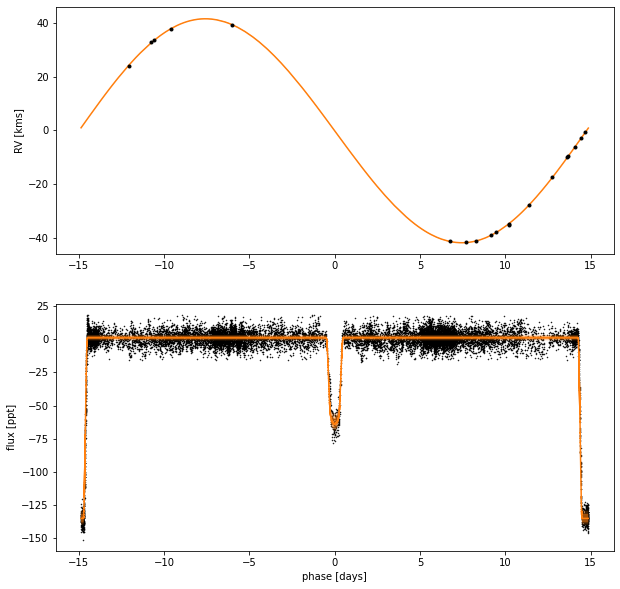

In [33]:
def run():
    p_med = flat_samps['period'].median().values
    t0_med = flat_samps['t0'].median().values
    mean_rv = flat_samps['mean_rv'].median().values
    mean_lc = flat_samps['mean_lc'].median().values
    # gp_pred = flat_samps['gp_pred'].median().values

    fig, axes = plt.subplots(figsize=(10,10), ncols=1, nrows=2)
    # print(flat_samps['ecc'].median())

    axes[0].errorbar(hf.fold(x_rv, p_med, t0_med),
                  y_rv, yerr=yerr_rv, fmt=".k")
    # rvvals = indres['rvvals']
    # lcvals = indres['lcvals']

    t_fold = hf.fold(trv, p_med, t0_med)
    inds = np.argsort(t_fold)
    pred = np.percentile(rvvals, [16, 50, 84], axis=0)
    axes[0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

    pred = np.percentile(rvvals, [16, 84], axis=0)
    art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
    art.set_edgecolor("none")

    pred = np.percentile(rvvals, [5, 95], axis=0)
    art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
    art.set_edgecolor("none")

    # pred = np.percentile(rvvals, [1, 99], axis=0)
    # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
    # art.set_edgecolor("none")
    # axes[0].set_ylim(-40, 40)
    # axes[1].set_ylim(-40, 40)
    axes[0].set_ylabel("RV [kms]")

    x,y = extras['x'],extras['y']
    # with model:
    #     gp_pred = (
    #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
    #     )


    axes[1].errorbar(hf.fold(x, p_med, t0_med),
                  y-gp_pred, fmt=".k", ms=1, zorder=-1)

    t_fold = hf.fold(tlc, p_med, t0_med)
    inds = np.argsort(t_fold)
    pred = np.percentile(lcvals, [16, 50, 84], axis=0)
    axes[1].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

    pred = np.percentile(lcvals, [16, 84], axis=0)
    art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
    art.set_edgecolor("none")

    pred = np.percentile(lcvals, [5, 95], axis=0)
    art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
    art.set_edgecolor("none")

    # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
    # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
    # art.set_edgecolor("none")

    axes[1].set_xlabel("phase [days]")
    axes[1].set_ylabel("flux [ppt]")
    plt.savefig(f"/Users/karljaehnig/CCA_work/GAT/apotess_systems/{TIC_TARGET.replace(' ','_')}_files/multi_model_RV_LC_curves.pdf", bbox_inches='tight')
run()

In [34]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_lc,1.058,1.125,-0.670,3.390,0.147,0.104,60.0,79.0,1.12
mean_rv,0.114,0.039,0.044,0.183,0.004,0.003,103.0,95.0,1.07
log_M1,-0.733,2.152,-4.825,2.612,0.512,0.368,18.0,27.0,1.67
log_R1,1.355,0.485,0.737,2.188,0.113,0.081,18.0,30.0,1.63
log_k,-1.355,0.030,-1.405,-1.303,0.002,0.002,144.0,120.0,1.00
log_q,0.494,1.223,-1.867,2.717,0.294,0.211,18.0,27.0,1.67
log_s,0.859,0.063,0.761,0.976,0.006,0.004,121.0,141.0,1.03
t0,1378.612,0.009,1378.597,1378.628,0.001,0.000,182.0,150.0,1.08
tn,1884.276,0.010,1884.258,1884.296,0.001,0.001,170.0,150.0,1.07
u1[0],0.265,0.189,0.003,0.592,0.021,0.015,90.0,150.0,1.08
